# In this notebook I use the Potts model coupling matrices to predict contacts!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from encoded_protein_dataset import EncodedProteinDataset, collate_fn, get_embedding
#from pseudolikelihood import get_npll
import torch
from potts_decoder import PottsDecoder
from torch.utils.data import DataLoader, RandomSampler
from functools import partial
import biotite.structure
from biotite.structure.io import pdbx, pdb
from biotite.structure.residues import get_residues
from biotite.structure import filter_backbone
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence
from typing import Sequence, Tuple, List
import scipy

import os
##TURIN HPC
sys.path.insert(1, "/Data/silva/esm/")

## EUROPA
#sys.path.insert(1, "/home/lucasilva/esm/")
import esm
#from esm.inverse_folding import util
import esm.pretrained as pretrained
from ioutils import read_fasta, read_encodings
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict


In [4]:
x=2

In [5]:
def get_npll(msas_embedded, couplings, fields, N, q):
    """ Get negative pseudo log likelihood (npll)
    """

    B, M, _ = msas_embedded.shape

    # (B, M, N*q) x (B, N*q, N*q) + (B, 1, N*q) -> (B, M, N*q) -> (B, M, N, q)
    A = (msas_embedded @ couplings + fields.unsqueeze(1)).view(B, M, N, q)

    # (B, M, N, q) -> (B, M, N)
    Z = torch.logsumexp(A, dim=-1)

    # (B, M, N, q) * (B, M, N, q) -> (B, M, N, q) -> (B, M, N)
    C = torch.sum(A * msas_embedded.view(B, M, N, q), dim=-1)

    # (B, M, N) - (B, M, N) -> (B, M, N)
    pll = C - Z

    return -pll
def load_structure(fpath, chain=None):
    """
    Args:
        fpath: filepath to either pdb or cif file
        chain: the chain id or list of chain ids to load
    Returns:
        biotite.structure.AtomArray
    """
    with open(fpath) as fin:
        pdbf = pdb.PDBFile.read(fin)
    structure = pdb.get_structure(pdbf, model=1)
    bbmask = filter_backbone(structure)
    structure = structure[bbmask]
    all_chains = get_chains(structure)
    if len(all_chains) == 0:
        raise ValueError('No chains found in the input file.')
    if chain is None:
        chain_ids = all_chains
    elif isinstance(chain, list):
        chain_ids = chain
    else:
        chain_ids = [chain] 
    for chain in chain_ids:
        if chain not in all_chains:
            raise ValueError(f'Chain {chain} not found in input file')
    chain_filter = [a.chain_id in chain_ids for a in structure]
    structure = structure[chain_filter]
    return structure

def extract_coords_from_structure(structure: biotite.structure.AtomArray):
    """
    Args:
        structure: An instance of biotite AtomArray
    Returns:
        Tuple (coords, seq)
            - coords is an L x 3 x 3 array for N, CA, C coordinates
            - seq is the extracted sequence
    """
    coords = get_atom_coords_residuewise(["N", "CA", "C"], structure)
    residue_identities = get_residues(structure)[1]
    seq = ''.join([ProteinSequence.convert_letter_3to1(r) for r in residue_identities])
    return coords, seq

def get_atom_coords_residuewise(atoms: List[str], struct: biotite.structure.AtomArray):
    """
    Example for atoms argument: ["N", "CA", "C"]
    """
    def filterfn(s, axis=None):
        filters = np.stack([s.atom_name == name for name in atoms], axis=1)
        sum = filters.sum(0)
        if not np.all(sum <= np.ones(filters.shape[1])):
            raise RuntimeError("structure has multiple atoms with same name")
        index = filters.argmax(0)
        coords = s[index].coord
        coords[sum == 0] = float("nan")
        return coords

    return biotite.structure.apply_residue_wise(struct, struct, filterfn)

In [6]:
torch.cuda.is_available()

True

In [4]:
input_encoding_dim = 512
q=21
param_embed_dim = 512
n_param_heads = 4
d_model = 128
n_heads = 2
n_layers = 2
device = 0
eta = 1e-3
dropout = 0.0


decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)

##TURIN HPC
##model_path = '/Data/InverseFoldingData/IntermediateModels/parameters_seed_0_batch_size_4_nheads_2_d_128_nparheads_4_dropout_0.1_eta_0.001_update_2000000_noise_0.02'

model_path = '/home/lucasilva/parameters_seed_0_batch_size_4_nheads_2_d_128_nparheads_4_dropout_0.1_eta_0.001_update_3000000_noise_0.02'
decoder.load_state_dict(torch.load(model_path, map_location='cpu'))
decoder.eval();


In [7]:
next(decoder.parameters()).device

device(type='cpu')

In [7]:
print(torch.version.cuda)

11.6


In [4]:
pretrained.esm_if1_gvp4_t16_142M_UR50

<function esm.pretrained.esm_if1_gvp4_t16_142M_UR50()>

In [7]:
model, alphabet = pretrained.esm_if1_gvp4_t16_142M_UR50() 
model.eval();

/Data/silva/esm/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [6]:
print(torch.__version__)

1.12.1


In [8]:
fname3 = 'EEHEE_rd3_0037.pdb'
pdb_folder3 = '/Data/InverseFoldingData/aan-designed-pdbs/rd3'
fpath3 = os.path.join(pdb_folder3, fname3)

structure =  load_structure(fpath3)
coords, native_seq = extract_coords_from_structure(structure)
rep = esm.inverse_folding.util.get_encoder_output(model, alphabet, coords)

rep_padded = pad_sequence(rep.unsqueeze(0), batch_first=True, padding_value=0.0)
padding_mask = torch.zeros((1, rep_padded.shape[1]), dtype=torch.bool)

#couplings, fields = decoder(rep_padded, padding_mask)

In [6]:
## Not very efficient but should work.
N = len(native_seq)
fields_2 = np.zeros(fields.shape[1:])
couplings_2 = np.zeros(couplings.shape[1:])
output = np.zeros((N, N))
for i in range(N):
    ## Let us force a zero-sum Gauge
    h_i = fields[0, i*21:(i+1)*21].detach().numpy()
    aux = np.zeros(q)
    for j in range(N):
        if j != i:
            c = couplings[0, i*21:(i+1)*21, j*21:(j+1)*21].detach().numpy()
            aux += (np.mean(c, axis=1) - np.mean(c))

    h_i = h_i - np.mean(h_i) + aux 
    fields_2[i*21:(i+1)*21] = h_i

    for j in range(i+1, N):
        c = couplings[0, i*21:(i+1)*21, j*21:(j+1)*21].detach().numpy()
        c = c - np.mean(c, axis=0).reshape((1, q)) - np.mean(c, axis=1).reshape((q, 1)) + np.mean(c)

        couplings_2[i*21:(i+1)*21, j*21:(j+1)*21] = c
        output[i,j] = np.sum(c**2)

In [7]:
## Given coords[i] we have a 3x3 matrix in which the rows are the 3D coordinates of the atoms inside the backbone! The middle one is the C-alpha, which is the center
## Of the backbone. We hence measure distances of amino acids as distances between alpha-carbons of different amino-acids.

distances = np.zeros((N, N))

for i in range(N):
    for j in range(i+1, N):
        distances[i,j] = np.sqrt(np.sum(coords[i][1,::]-coords[j][1,::])**2)
        distances[j,i] = distances[i,j]

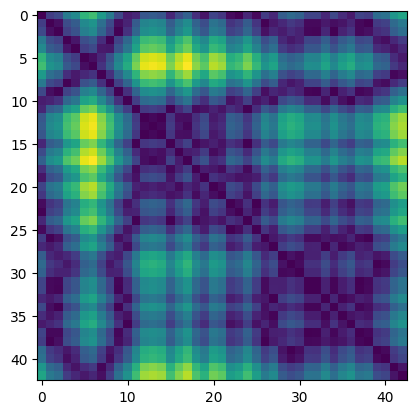

In [8]:
plt.imshow(distances)

In [9]:
def contacts(distances, skip=4, threshold=8):
    cont = np.zeros(distances.shape)
    for i in range(distances.shape[0]):
        cont[i, ::] = [(lambda j: (distances[i,j]<threshold and abs(i-j)>skip))(j) for j in range(distances.shape[0])]
    return cont

In [10]:
cont = contacts(distances)

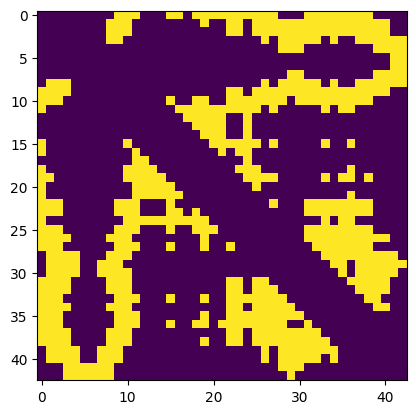

In [11]:
plt.imshow(cont)

We also apply the typical APC correction for contact prediction

In [12]:
output_full = output + np.transpose(output)
output_corrected = np.zeros(output_full.shape)
mean_i = np.mean(output_full, axis=0).reshape((1, N))
mean_j = np.mean(output_full, axis=1).reshape((N, 1))
#output_corrected = output_full - np.transpose(np.dot(mean_j, mean_i))/np.mean(output_full)

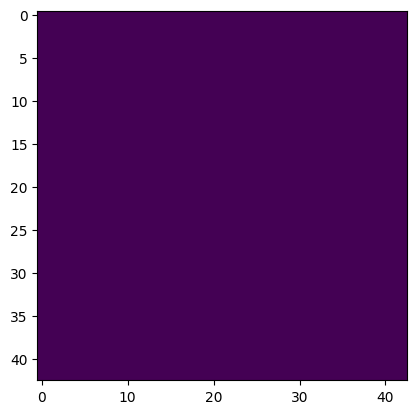

In [13]:
plt.imshow(output_corrected)

In [15]:
for i in range(N):
    for j in range(i+1, N):
        output_corrected[i,j] = output_full[i,j]- mean_i[0,i]*mean_j[j,0]/np.mean(output_full)
        output_corrected[j,i] = output_corrected[i,j]

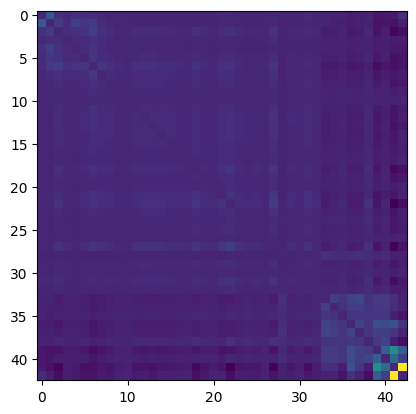

In [16]:
plt.imshow(output_corrected)

In [23]:
contact_pred_apc =  np.zeros((N,N))
for i in range(N):
    indices = np.argsort(-output_corrected[i, ::])
    n_cont = 0
    idx = 0
    while n_cont<5:
        if abs(indices[idx]-i)>4:
            contact_pred_apc[i, indices[idx]] = 1
            contact_pred_apc[indices[idx], i] = 1
            n_cont+=1
        idx+=1

In [24]:
contact_pred =  np.zeros((N,N))
for i in range(N):
    indices = np.argsort(-output_full[i, ::])
    n_cont = 0
    idx = 0
    while n_cont<5:
        if abs(indices[idx]-i)>4:
            contact_pred[i, indices[idx]] = 1
            contact_pred[indices[idx], i] = 1
            n_cont+=1
        idx+=1

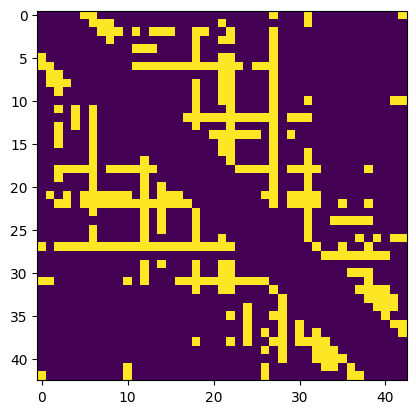

In [25]:
plt.imshow(contact_pred_apc)

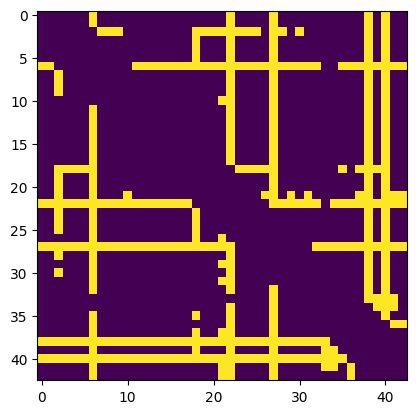

In [26]:
plt.imshow(contact_pred)

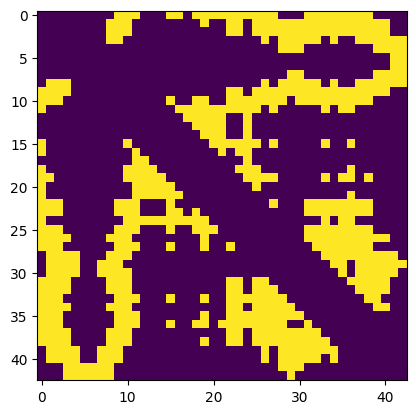

In [73]:
plt.imshow(cont)

In [76]:
np.exp(1.9)

6.6858944422792685

Perplexity calculation:

- We would like to compare our results with the perplexity of the paper of ESM, unfortunately we cannot calculate the likelihood of our predicted model, as that is the central problem of Potts models.
- We would like to assess if we could calculate the pseudo likelihood for the model given by ESM and compare it with our results to get a benchmark to measure against.
- We shall remember that our task is harder, as we don't give the model the exact native sequence, but give a batch of the MSA in which we often don't have the true sequence. 

In [28]:
?esm.inverse_folding.util.get_sequence_loss

Signature: esm.inverse_folding.util.get_sequence_loss(model, alphabet, coords, seq)
Docstring: <no docstring>
File:      /Data/silva/esm/esm/inverse_folding/util.py
Type:      function


In [11]:
res2 = esm.inverse_folding.util.get_sequence_loss(model, alphabet, coords, native_seq)

In [13]:
len(res2[0])

43

In [14]:
coords.shape

(43, 3, 3)

In [16]:
len(native_seq)

43

In [34]:
likelihood = np.prod(res[0])

In [35]:
likelihood

6.168716e-11

In [17]:
res = esm.inverse_folding.util.score_sequence(model, alphabet, coords, native_seq)

In [18]:
res

(-1.5181583138399346, -1.5181583138399346)

In [41]:
-np.sum(res2[0])/43

-1.5181583138399346

Ok now we have everything, we can hence write a code that gives us the the pseudolikelihood of esm to get a benchmark for our model!

The main observation is that:
$$ p(y_i|y_{-i}) = \frac{p(y)}{p(y_{-i})} = \frac{p(y)}{\sum_{a}p(y_i=a, y_{-i})}, $$
which, since it involves marginalizing over just one position of the sequence is clearly computationally feasible!

In [76]:
def get_sequence_loss(model, alphabet, coords, seq):
    batch_converter = CoordBatchConverter(alphabet)
    batch = [(coords, None, seq)]
    coords, confidence, strs, tokens, padding_mask = batch_converter(batch)
    
    prev_output_tokens = tokens[:, :-1]
    target = tokens[:, 1:]
    target_padding_mask = (target == alphabet.padding_idx)
    logits, _ = model.forward(coords, padding_mask, confidence, prev_output_tokens)
    loss = F.cross_entropy(logits, target, reduction='none')
    loss = loss[0].detach().numpy()
    target_padding_mask = target_padding_mask[0].numpy()
    return loss, target_padding_mask

class BatchConverter(object):
    """Callable to convert an unprocessed (labels + strings) batch to a
    processed (labels + tensor) batch.
    """

    def __init__(self, alphabet, truncation_seq_length: int = None):
        self.alphabet = alphabet
        self.truncation_seq_length = truncation_seq_length

    def __call__(self, raw_batch: Sequence[Tuple[str, str]]):
        # RoBERTa uses an eos token, while ESM-1 does not.
        batch_size = len(raw_batch)
        batch_labels, seq_str_list = zip(*raw_batch)
        seq_encoded_list = [self.alphabet.encode(seq_str) for seq_str in seq_str_list]
        if self.truncation_seq_length:
            seq_encoded_list = [seq_str[:self.truncation_seq_length] for seq_str in seq_encoded_list]
        max_len = max(len(seq_encoded) for seq_encoded in seq_encoded_list)
        tokens = torch.empty(
            (
                batch_size,
                max_len + int(self.alphabet.prepend_bos) + int(self.alphabet.append_eos),
            ),
            dtype=torch.int64,
        )
        tokens.fill_(self.alphabet.padding_idx)
        labels = []
        strs = []

        for i, (label, seq_str, seq_encoded) in enumerate(
            zip(batch_labels, seq_str_list, seq_encoded_list)
        ):
            labels.append(label)
            strs.append(seq_str)
            if self.alphabet.prepend_bos:
                tokens[i, 0] = self.alphabet.cls_idx
            seq = torch.tensor(seq_encoded, dtype=torch.int64)
            tokens[
                i,
                int(self.alphabet.prepend_bos) : len(seq_encoded)
                + int(self.alphabet.prepend_bos),
            ] = seq
            if self.alphabet.append_eos:
                tokens[i, len(seq_encoded) + int(self.alphabet.prepend_bos)] = self.alphabet.eos_idx

        return labels, strs, tokens


class CoordBatchConverter(BatchConverter):
    def __call__(self, raw_batch: Sequence[Tuple[Sequence, str]], device=None):
        """
        Args:
            raw_batch: List of tuples (coords, confidence, seq)
            In each tuple,
                coords: list of floats, shape L x 3 x 3
                confidence: list of floats, shape L; or scalar float; or None
                seq: string of length L
        Returns:
            coords: Tensor of shape batch_size x L x 3 x 3
            confidence: Tensor of shape batch_size x L
            strs: list of strings
            tokens: LongTensor of shape batch_size x L
            padding_mask: ByteTensor of shape batch_size x L
        """
        self.alphabet.cls_idx = self.alphabet.get_idx("<cath>") 
        batch = []
        for coords, confidence, seq in raw_batch:
            if confidence is None:
                confidence = 1.
            if isinstance(confidence, float) or isinstance(confidence, int):
                confidence = [float(confidence)] * len(coords)
            if seq is None:
                seq = 'X' * len(coords)
            batch.append(((coords, confidence), seq))

        coords_and_confidence, strs, tokens = super().__call__(batch)

        # pad beginning and end of each protein due to legacy reasons
        coords = [
            F.pad(torch.tensor(cd), (0, 0, 0, 0, 1, 1), value=np.inf)
            for cd, _ in coords_and_confidence
        ]
        confidence = [
            F.pad(torch.tensor(cf), (1, 1), value=-1.)
            for _, cf in coords_and_confidence
        ]
        coords = self.collate_dense_tensors(coords, pad_v=np.nan)
        confidence = self.collate_dense_tensors(confidence, pad_v=-1.)
        if device is not None:
            coords = coords.to(device)
            confidence = confidence.to(device)
            tokens = tokens.to(device)
        padding_mask = torch.isnan(coords[:,:,0,0])
        coord_mask = torch.isfinite(coords.sum(-2).sum(-1))
        confidence = confidence * coord_mask + (-1.) * padding_mask
        return coords, confidence, strs, tokens, padding_mask

    def from_lists(self, coords_list, confidence_list=None, seq_list=None, device=None):
        """
        Args:
            coords_list: list of length batch_size, each item is a list of
            floats in shape L x 3 x 3 to describe a backbone
            confidence_list: one of
                - None, default to highest confidence
                - list of length batch_size, each item is a scalar
                - list of length batch_size, each item is a list of floats of
                    length L to describe the confidence scores for the backbone
                    with values between 0. and 1.
            seq_list: either None or a list of strings
        Returns:
            coords: Tensor of shape batch_size x L x 3 x 3
            confidence: Tensor of shape batch_size x L
            strs: list of strings
            tokens: LongTensor of shape batch_size x L
            padding_mask: ByteTensor of shape batch_size x L
        """
        batch_size = len(coords_list)
        if confidence_list is None:
            confidence_list = [None] * batch_size
        if seq_list is None:
            seq_list = [None] * batch_size
        raw_batch = zip(coords_list, confidence_list, seq_list)
        return self.__call__(raw_batch, device)

    @staticmethod
    def collate_dense_tensors(samples, pad_v):
        """
        Takes a list of tensors with the following dimensions:
            [(d_11,       ...,           d_1K),
             (d_21,       ...,           d_2K),
             ...,
             (d_N1,       ...,           d_NK)]
        and stack + pads them into a single tensor of:
        (N, max_i=1,N { d_i1 }, ..., max_i=1,N {diK})
        """
        if len(samples) == 0:
            return torch.Tensor()
        if len(set(x.dim() for x in samples)) != 1:
            raise RuntimeError(
                f"Samples has varying dimensions: {[x.dim() for x in samples]}"
            )
        (device,) = tuple(set(x.device for x in samples))  # assumes all on same device
        max_shape = [max(lst) for lst in zip(*[x.shape for x in samples])]
        result = torch.empty(
            len(samples), *max_shape, dtype=samples[0].dtype, device=device
        )
        result.fill_(pad_v)
        for i in range(len(samples)):
            result_i = result[i]
            t = samples[i]
            result_i[tuple(slice(0, k) for k in t.shape)] = t
        return result

In [ ]:
def marginalize(model, coords, native_seq, restr_alphabet, alphabet_esm, i):
    """ This gives the normalizing factor at different positions"""
    if native_seq[i] not in restr_alphabet:
        raise ValueError("Error! Character is not in the resitricted dataset.")
    ## I want to calculate the probability for the restricted dataset 
    norm = 0
    for char in restr_alphabet:
        mutated_seq = list(native_seq)
        mutated_seq[0] = char
        mutated_seq = "".join(mutated_seq)
        res = esm.inverse_folding.util.score_sequence(model, alphabet_esm, coords, mutated_seq)[0]
        norm += np.exp(res)
    return norm

    

def get_loss_esm(model, restr_alphabet, alphabet_esm, coords, native_seq):
    N = coords.shape[0]
    part = 0
    for i in range(N):
        norm = marginalize(model, coords, native_seq, restr_alphabet, alphabet_esm, i)
        part += np.exp(esm.inverse_folding.util.score_sequence(model, alphabet_esm, coords, native_seq)[0])/norm
    return part/N

In [30]:
ab = 'ACDEFGHIKLMNPQRSTVWY-'
for letter in alphabet.standard_toks:
    if letter not in ab:
        print(letter)

X
B
U
Z
O
.


In [13]:
#alphabet.all_toks

In [77]:
import torch.nn.functional as F

In [ ]:
model, alphabet = pretrained.esm_if1_gvp4_t16_142M_UR50() 
model.eval();

In [ ]:
ab = 'ACDEFGHIKLMNPQRSTVWY-'
marginalize(model, coords, ab, alphabet, 0)

In [45]:
batch_converter = CoordBatchConverter(alphabet)
batch = [(coords, None, native_seq)]
## Tokens is the numerical sequence representation of the native sequences!
coords, confidence, strs, tokens, padding_mask = batch_converter(batch)

## We now want to calculate the pseudo likelihood for the esm model

In [ ]:
fname3 = 'EEHEE_rd3_0037.pdb'
pdb_folder3 = '/Data/InverseFoldingData/aan-designed-pdbs/rd3'
fpath3 = os.path.join(pdb_folder3, fname3)

structure =  load_structure(fpath3)
coords, native_seq = extract_coords_from_structure(structure)
rep = esm.inverse_folding.util.get_encoder_output(model, alphabet, coords)

rep_padded = pad_sequence(rep.unsqueeze(0), batch_first=True, padding_value=0.0)
padding_mask = torch.zeros((1, rep_padded.shape[1]), dtype=torch.bool)

In [67]:
mutated_seq = list(native_seq)
mutated_seq[0] = 'X'
mutated_seq = "".join(mutated_seq)

In [68]:
mutated_seq

'XTIKVNGQEYTVPLSPEQAAKAAKKRWPDYEVQIHGNTVKVTR'

In [69]:
native_seq

'TTIKVNGQEYTVPLSPEQAAKAAKKRWPDYEVQIHGNTVKVTR'

In [49]:
ab = 'ACDEFGHIKLMNPQRSTVWY-'
for ac in native_seq:
    if ac not in ab:
        print(ac)

In [46]:
prev_output_tokens = tokens[:, :-1]
target = tokens[:, 1:]
target_padding_mask = (target == alphabet.padding_idx)
logits, _ = model.forward(coords, padding_mask, confidence, prev_output_tokens)
loss = F.cross_entropy(logits, target, reduction='none')
loss = loss[0].detach().numpy()
target_padding_mask = target_padding_mask[0].numpy()

In [62]:
prev_output_tokens

tensor([[33, 11, 11, 12, 15,  7, 17,  6, 16,  9, 19, 11,  7, 14,  4,  8, 14,  9,
         16,  5,  5, 15,  5,  5, 15, 15, 10, 22, 14, 13, 19,  9,  7, 16, 12, 21,
          6, 17, 11,  7, 15,  7, 11]])

In [64]:
target = tokens[:, 1:]
target

tensor([[11, 11, 12, 15,  7, 17,  6, 16,  9, 19, 11,  7, 14,  4,  8, 14,  9, 16,
          5,  5, 15,  5,  5, 15, 15, 10, 22, 14, 13, 19,  9,  7, 16, 12, 21,  6,
         17, 11,  7, 15,  7, 11, 10]])

In [91]:
len(tokens[0])

44

In [65]:
logits, _ = model.forward(coords, padding_mask, confidence, prev_output_tokens)

In [76]:
logits[0, 4:23, 0]

tensor([-0.8052,  0.8779,  4.2694,  0.3729,  1.0794, -0.3205, -0.6565,  0.8230,
        -0.9357, -0.5373, -0.2297, -0.6499, -0.8553, -0.5040, -1.4133, -1.3378,
         1.9648, -0.0313, -1.7673], grad_fn=<SelectBackward0>)

In [26]:
#alphabet.all_toks[4:27]

In [96]:
ab = 'ACDEFGHIKLMNPQRSTVWY-'
default_char = '-'

In [94]:
from collections import defaultdict

In [97]:
default_index = ab.index(default_char)
aa_index = defaultdict(lambda: default_index, {ab[i]: i for i in range(len(ab))})
tokens2=torch.Tensor([aa_index[c] for c in str(native_seq) if c.isupper() or c == '-'])

In [98]:
tokens2

tensor([16., 16.,  7.,  8., 17., 11.,  5., 13.,  3., 19., 16., 17., 12.,  9.,
        15., 12.,  3., 13.,  0.,  0.,  8.,  0.,  0.,  8.,  8., 14., 18., 12.,
         2., 19.,  3., 17., 13.,  7.,  6.,  5., 11., 16., 17.,  8., 17., 16.,
        14.])

In [99]:
tokens

tensor([[33, 11, 11, 12, 15,  7, 17,  6, 16,  9, 19, 11,  7, 14,  4,  8, 14,  9,
         16,  5,  5, 15,  5,  5, 15, 15, 10, 22, 14, 13, 19,  9,  7, 16, 12, 21,
          6, 17, 11,  7, 15,  7, 11, 10]])